In [3]:
import tensorflow as tf
import keras_tuner as kt
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model

# GPU 사용 가능 여부 확인
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# GPU 메모리 증가 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # Get GPU memory info using nvidia-smi
            import subprocess
            def get_gpu_memory():
                command = "nvidia-smi --query-gpu=memory.total --format=csv,noheader,nounits"
                memory_total = subprocess.check_output(command.split()).decode('ascii').strip().split('\n')[0]
                return int(memory_total)
            
            total_memory = get_gpu_memory()
            print(f'GPU {gpu.name} memory limit: {total_memory/1024:.2f} GB')
    except (RuntimeError, FileNotFoundError, subprocess.CalledProcessError) as e:
        print(f"Error getting GPU info: {e}")

# GPU 장치 설정
try:
    print('Default GPU: {}'.format(tf.test.gpu_device_name()))
except Exception as e:
    print(f"Error while finding GPUs: {e}")
    print(f"Available GPUs: {gpus[0].name}")

keras.mixed_precision.set_global_policy('mixed_float16')

TensorFlow version: 2.18.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU /physical_device:GPU:0 memory limit: 12.00 GB
Default GPU: /device:GPU:0


I0000 00:00:1736413355.271950  184494 gpu_device.cc:2022] Created device /device:GPU:0 with 9571 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


## Not Using a Pre-trained Model
### Training ConvNet from Scratch
#### Preparing dogs-vs-cats dataset

In [5]:
import shutil, pathlib

# directory path of the original dataset
original_dir = pathlib.Path('./dogs-vs-cats/train')
new_base_dir = pathlib.Path('./dogs-vs-cats_small')

# organize the dataset into train, validation, and test sets
def make_subset(subset_name, start_index, end_index):
    for category in ("dog", "cat"):
        dir = new_base_dir / subset_name / category
        pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
        
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        
        for fname in fnames:
            shutil.copyfile(src = original_dir / fname,
                            dst = dir / fname)

make_subset("train", 0, 1000)
make_subset("validation", 1000, 1500)
make_subset("test", 1500, 2500)

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

# loading the dataset into the memory in batches
train_dataset = image_dataset_from_directory(
    directory = new_base_dir / 'train',
    image_size = (180, 180),
    batch_size = 32
)

validation_dataset = image_dataset_from_directory(
    directory = new_base_dir / 'validation',
    image_size = (180, 180),
    batch_size = 32
)

test_dataset = image_dataset_from_directory(
    directory = new_base_dir / 'test',
    image_size = (180, 180),
    batch_size = 32
)

Found 2000 files belonging to 2 classes.


I0000 00:00:1736413377.625535  184494 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9571 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [4]:
# checking the shape of the data and labels
for data_batch, labels_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


#### Preparing the Scratch-Model

In [5]:
# designing and compiling the model
convnet_inputs = keras.Input(shape=(180, 180, 3))

convnet_layer = layers.Rescaling(1.0/255)(convnet_inputs)
convnet_layer = layers.Conv2D(filters = 32, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.MaxPooling2D(pool_size = 2)(convnet_layer)
convnet_layer = layers.Conv2D(filters = 64, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.MaxPooling2D(pool_size = 2)(convnet_layer)
convnet_layer = layers.Conv2D(filters = 128, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.MaxPooling2D(pool_size = 2)(convnet_layer)
convnet_layer = layers.Conv2D(filters = 256, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.MaxPooling2D(pool_size = 2)(convnet_layer)
convnet_layer = layers.Conv2D(filters = 256, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.Flatten()(convnet_layer)

convnet_outputs = layers.Dense(1, activation='sigmoid')(convnet_layer)
convnet_model = keras.Model(inputs = convnet_inputs, outputs = convnet_outputs, name="convnet_from_scratch")

convnet_model.summary()

convnet_model.compile(optimizer='rmsprop',
            loss='binary_crossentropy',
            metrics=['accuracy'])

Model: "convnet_from_scratch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# defining a callback to save the best model
def checkpoint_save(filepath):
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = filepath,
        save_best_only = True,
        monitor = 'val_loss',
    )
    return checkpoint

In [7]:
# training the model
conv_history = convnet_model.fit(
    train_dataset,
    epochs = 30,
    validation_data = validation_dataset,
    callbacks = checkpoint_save("convnet_from_scratch.keras")
)

Epoch 1/30


I0000 00:00:1736328661.977542  921240 service.cc:148] XLA service 0x7f5de000b460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736328661.977615  921240 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-01-08 18:31:02.017609: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736328662.190641  921240 cuda_dnn.cc:529] Loaded cuDNN version 90600
2025-01-08 18:31:04.122478: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=3,k3=0} for conv (f16[32,178,178,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,180,180,3]{3,2,1,0}, f16[32,3,3,3]{3,2,1,0}, f16[32]{0}), window={size=3x3}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_resu

15/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4685 - loss: 0.7158

I0000 00:00:1736328671.606423  921240 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.4886 - loss: 0.7028 - val_accuracy: 0.5000 - val_loss: 0.6983
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4618 - loss: 0.7056 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5346 - loss: 0.7091 - val_accuracy: 0.5340 - val_loss: 0.6784
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5796 - loss: 0.6849 - val_accuracy: 0.6010 - val_loss: 0.6491
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6284 - loss: 0.6714 - val_accuracy: 0.6170 - val_loss: 0.6637
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6465 - loss: 0.6218 - val_accuracy: 0.6320 - val_loss: 0.6295
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6875 - loss: 0.6032 - val_accuracy: 0.6660 - val_loss: 0.6285
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7155 - loss: 0.5645 - val_accuracy: 0.6800 - val_loss: 0

#### Visualizing Model-Training History
##### Defining plotting function

In [8]:
# defining a function to plot the training history
def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.plot(accuracy, label='accuracy')
    ax1.plot(val_accuracy, label='val_accuracy')
    ax1.legend()

    ax2.plot(loss, label='loss')
    ax2.plot(val_loss, label='val_loss')
    ax2.legend()

    plt.legend()
    plt.show()

##### Plotting and visualizing the training history

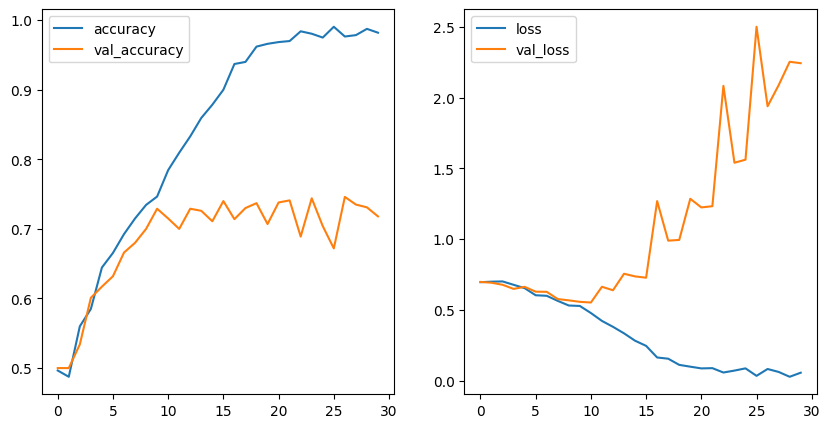

In [9]:
# plotting the training history
plot_history(conv_history)

In [10]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7168 - loss: 0.5961
Test accuracy: 0.707


In [9]:
# designing the data augmentation pipeline
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])


In [ ]:

# visualizing the augmented images
plt.figure(figsize=(10, 10))

for images, _ in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(images)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis('off')
    plt.show()

In [12]:
# designing and compiling the model with data augmentation
convnet_inputs = keras.Input(shape=(180, 180, 3))

convnet_layer = data_augmentation(convnet_inputs)
convnet_layer = layers.Rescaling(1.0/255)(convnet_layer)
convnet_layer = layers.Conv2D(filters = 32, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.MaxPooling2D(pool_size = 2)(convnet_layer)
convnet_layer = layers.Conv2D(filters = 64, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.MaxPooling2D(pool_size = 2)(convnet_layer)
convnet_layer = layers.Conv2D(filters = 128, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.MaxPooling2D(pool_size = 2)(convnet_layer)
convnet_layer = layers.Conv2D(filters = 256, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.MaxPooling2D(pool_size = 2)(convnet_layer)
convnet_layer = layers.Conv2D(filters = 256, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.Flatten()(convnet_layer)
convnet_layer = layers.Dropout(0.5)(convnet_layer)
convnet_outputs = layers.Dense(1, activation='sigmoid')(convnet_layer)
convnet_model = keras.Model(inputs = convnet_inputs, outputs = convnet_outputs, name="convnet_from_scratch_augmented")

convnet_model.summary()

convnet_model.compile(optimizer='rmsprop',
            loss='binary_crossentropy',
            metrics=['accuracy'])

Model: "convnet_from_scratch_augmented"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_2 (Cast)                   │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# training the model with data augmentation
convnet_aug_history = convnet_model.fit(
    train_dataset,
    epochs = 100,
    validation_data = validation_dataset,
    callbacks = checkpoint_save("convnet_from_scratch_augmented.keras")
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.5098 - loss: 0.7219 - val_accuracy: 0.5000 - val_loss: 0.6950
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4994 - loss: 0.6964 - val_accuracy: 0.5350 - val_loss: 0.6844
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5154 - loss: 0.7123 - val_accuracy: 0.5240 - val_loss: 0.6757
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5760 - loss: 0.6732 - val_accuracy: 0.5530 - val_loss: 0.9081
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6233 - loss: 0.6620 - val_accuracy: 0.6260 - val_loss: 0.6298
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6534 - loss: 0.6350 - val_accuracy: 0.6320 - val_loss: 0.6347
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6555 - loss: 0.6258 - val_accuracy: 0.6880 - val_loss: 0.5821
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6612 - loss: 0.6180 - val_accuracy: 0.

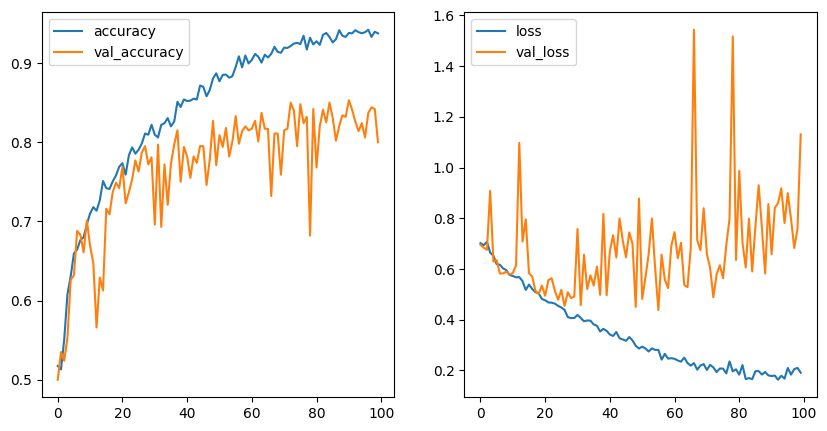

In [14]:
# plotting the training history
plot_history(convnet_aug_history)

In [15]:
# evaluating the model on the test set
convnet_aug_best = keras.models.load_model("convnet_from_scratch_augmented.keras")
convnet_aug_best_loss, convnet_aug_best_acc = convnet_aug_best.evaluate(test_dataset)
print(f"Test accuracy: {convnet_aug_best_acc:.3f}")

convnet_aug_best.summary()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8306 - loss: 0.4799
Test accuracy: 0.836


Model: "convnet_from_scratch_augmented"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_3 (Cast)                   │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,982,088 (7.56 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 991,047 (3.78 MB)

## Using Advanced Architecture

Epoch 1/100


2025-01-09 18:04:38.878371: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1736413479.390404  184738 cuda_dnn.cc:529] Loaded cuDNN version 90600


63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 327ms/step - accuracy: 0.5178 - loss: 0.9190 - val_accuracy: 0.5100 - val_loss: 0.6929
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.5867 - loss: 0.6857 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy: 0.6092 - loss: 0.6497 - val_accuracy: 0.5000 - val_loss: 0.7065
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.6110 - loss: 0.6506 - val_accuracy: 0.5000 - val_loss: 0.7186
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.6443 - loss: 0.6328 - val_accuracy: 0.5000 - val_loss: 0.7511
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.6559 - loss: 0.6157 - val_accuracy: 0.5270 - val_loss: 0.6975
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.6794 - loss: 0.6054 - val_accuracy: 0.5140 - val_loss: 0.7590
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.6863 - loss: 0.5934 - val_accuracy: 0.5000

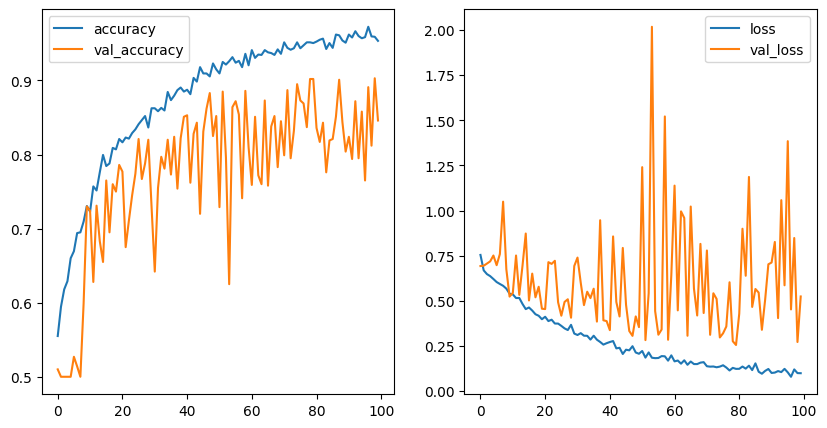

In [13]:
inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
	residual = x
	
	x = layers.BatchNormalization()(x)
	x = layers.Activation("relu")(x)
	x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
	
	x = layers.BatchNormalization()(x)
	x = layers.Activation("relu")(x)
	x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
	
	x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
	
	residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
	x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
convnet_adv_architecture = keras.Model(inputs=inputs, outputs=outputs)

convnet_adv_architecture.compile(optimizer='rmsprop',
								loss='binary_crossentropy',
								metrics=['accuracy'])

convnet_adv_history = convnet_adv_architecture.fit(
    train_dataset,
    epochs = 100,
    validation_data = validation_dataset,
    callbacks = checkpoint_save("convnet_from_scratch_augmented.keras")
)

plot_history(convnet_adv_history)

In [14]:
# evaluating the model on the test set
convnet_adv_best = keras.models.load_model("convnet_from_scratch_augmented.keras")
convnet_adv_best_loss, convnet_adv_best_acc = convnet_adv_best.evaluate(test_dataset)
print(f"Test accuracy: {convnet_adv_best_acc:.3f}")

convnet_adv_best.summary()

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8970 - loss: 0.3343
Test accuracy: 0.891


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_3 (Cast)       │ (None, 180, 180,  │          0 │ input_layer_4[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ cast_3[0][0]      │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 180, 180,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 176, 176,  │      2,400 │ rescaling_2[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 176, 176,  │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_20 │ (None, 176, 176,  │      1,312 │ activation_20[0]… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 176, 176,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_21 │ (None, 176, 176,  │      1,312 │ activation_21[0]… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 88, 88,    │          0 │ separable_conv2d… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 88, 88,    │      1,024 │ conv2d_12[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 88, 88,    │          0 │ max_pooling2d_10… │
│                     │ 32)               │            │ conv2d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 88,    │        128 │ add_10[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 88, 88,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_22 │ (None, 88, 88,    │      2,336 │ activation_22[0]

 Total params: 1,440,712 (5.50 MB)

 Trainable params: 718,849 (2.74 MB)

 Non-trainable params: 3,008 (11.75 KB)

 Optimizer params: 718,855 (2.74 MB)

## Using a Pre-Trained Model (VGG16)
### Feature-Extraction using the Pre-Trained Model
#### Loading the Model

In [16]:
# loading the pre-trained base of VGG16
vgg16_base = keras.applications.VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (180, 180, 3)
)

vgg16_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_4 (Cast)                   │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

#### Extracting Features amd Labels

In [17]:
# Extracting features from the dataset using the pre-trained VGG16 base
def get_feature_and_labels(dataset):
    all_features = []
    all_labels = []

    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = vgg16_base(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)

    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_feature_and_labels(train_dataset)
val_features, val_labels = get_feature_and_labels(validation_dataset)
test_features, test_labels = get_feature_and_labels(test_dataset)

train_features.shape, val_features.shape, test_features.shape

2025-01-08 18:34:40.913690: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-08 18:34:43.869574: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


((2000, 5, 5, 512), (1000, 5, 5, 512), (2000, 5, 5, 512))

#### Training Top(=MLP) Model

In [18]:

vgg16_top_input = keras.Input(shape=(5, 5, 512))

vgg16_top_layer = layers.Flatten()(vgg16_top_input)
vgg16_top_layer = layers.Dense(256, activation='relu')(vgg16_top_layer)
vgg16_top_layer = layers.Dropout(0.5)(vgg16_top_layer)

vgg16_top_output = layers.Dense(1, activation='sigmoid')(vgg16_top_layer)
vgg16_top = keras.Model(inputs = vgg16_top_input, outputs = vgg16_top_output, name="vgg16_top")

vgg16_top.compile(optimizer='rmsprop',
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [19]:
vgg16_top_history = vgg16_top.fit(
    train_features, train_labels,
    epochs = 20,
    validation_data = (val_features, val_labels),
    callbacks = checkpoint_save("vgg16_top.keras")
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7705 - loss: 3.3115

2025-01-08 18:34:47.164288: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 4 bytes spill stores, 4 bytes spill loads

2025-01-08 18:34:47.259709: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 52 bytes spill stores, 52 bytes spill loads

2025-01-08 18:34:47.819848: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 4 bytes spill stores, 4 bytes spill loads



63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7718 - loss: 3.2929 - val_accuracy: 0.9570 - val_loss: 0.6406
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9093 - loss: 1.3890 - val_accuracy: 0.9580 - val_loss: 0.5941
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9334 - loss: 1.0461 - val_accuracy: 0.9240 - val_loss: 1.1376
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9296 - loss: 1.0559 - val_accuracy: 0.9700 - val_loss: 0.4672
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9573 - loss: 0.6407 - val_accuracy: 0.9270 - val_loss: 1.1134
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9451 - loss: 0.8295 - val_accuracy: 0.9660 - val_loss: 0.5229
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9612 - loss: 0.6039 - val_accuracy: 0.9710 - val_loss: 0.4530
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9554 - loss: 0.6770 - val_accuracy: 0.9710 - val_loss: 0.4637
Ep

#### Visualising Model-Training history

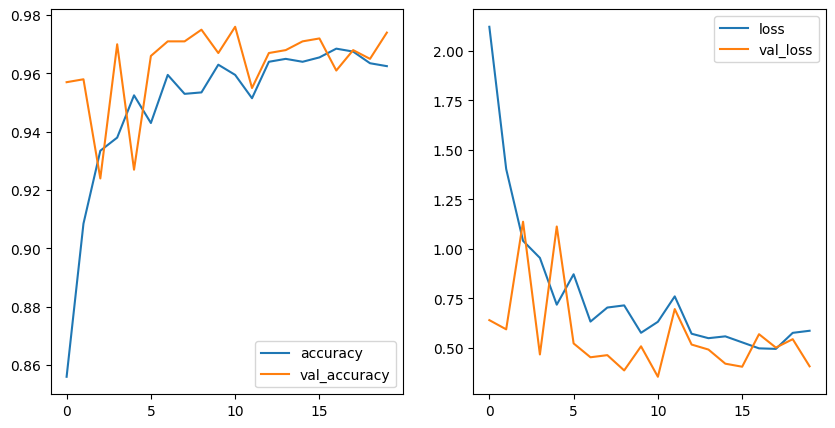

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9676 - loss: 0.5112

2025-01-08 18:34:55.477807: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 4 bytes spill stores, 4 bytes spill loads



63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9678 - loss: 0.5081
Test accuracy: 0.971


Model: "vgg16_top"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_6 (Cast)                   │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,554,632 (25.00 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,277,319 (12.50 MB)

In [20]:
# plotting the training history
plot_history(vgg16_top_history)

vgg16_top_best = keras.models.load_model("vgg16_top.keras")
vgg16_loss, vgg16_acc = vgg16_top_best.evaluate(test_features, test_labels)
print(f"Test accuracy: {vgg16_acc:.3f}")

vgg16_top_best.summary()

### Buildign the End-To-End Model on a Pre-Trained Model
#### Reloading and Freezing the Model

In [21]:
# freezing pre-trained VGG16 base to train the top layers
vgg16_base_freeze = keras.applications.VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (180, 180, 3)
)

vgg16_base_freeze.trainable = False
vgg16_base_freeze.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_7 (Cast)                   │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

#### Building the End-To-End Model with Data Augmentation

In [22]:
# designing and compiling the model with the frozen pre-trained VGG16 base
vgg16_freeze_input = keras.Input(shape=(180, 180, 3))

vgg16_freeze_layers = data_augmentation(vgg16_freeze_input)
vgg16_freeze_layers = keras.applications.vgg16.preprocess_input(vgg16_freeze_layers)
vgg16_freeze_layers = vgg16_base_freeze(vgg16_freeze_layers)
vgg16_freeze_layers = layers.Flatten()(vgg16_freeze_layers)
vgg16_freeze_layers = layers.Dense(256, activation='relu')(vgg16_freeze_layers)
vgg16_freeze_layers = layers.Dropout(0.5)(vgg16_freeze_layers)

vgg16_freeze_output = layers.Dense(1, activation='sigmoid')(vgg16_freeze_layers)
vgg16_freeze_model = keras.Model(inputs = vgg16_freeze_input, outputs = vgg16_freeze_output, name="vgg16_freeze")
vgg16_freeze_model.compile(optimizer='rmsprop',
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

In [23]:
# training the model with the frozen pre-trained VGG16 base
vgg16_freeze_history = vgg16_freeze_model.fit(
    train_dataset,
    epochs = 50,
    validation_data = validation_dataset,
    callbacks = checkpoint_save("vgg16_freeze.keras")
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.4914 - loss: 8.0113 - val_accuracy: 0.5000 - val_loss: 8.0590
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.5265 - loss: 7.5860 - val_accuracy: 0.8060 - val_loss: 3.0299
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8205 - loss: 2.7752 - val_accuracy: 0.9530 - val_loss: 0.7419
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9008 - loss: 1.5077 - val_accuracy: 0.9160 - val_loss: 1.2669
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8851 - loss: 1.7795 - val_accuracy: 0.9620 - val_loss: 0.5898
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9212 - loss: 1.1898 - val_accuracy: 0.9640 - val_loss: 0.5381
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9194 - loss: 1.2322 - val_accuracy: 0.9510 - val_loss: 0.7623
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8877 - loss: 1.6944 - val_accuracy: 0.9620 - v

In [ ]:
dogs-vs-cats/
dogs-vs-cats_small/

#### Visualizing Model-Training History

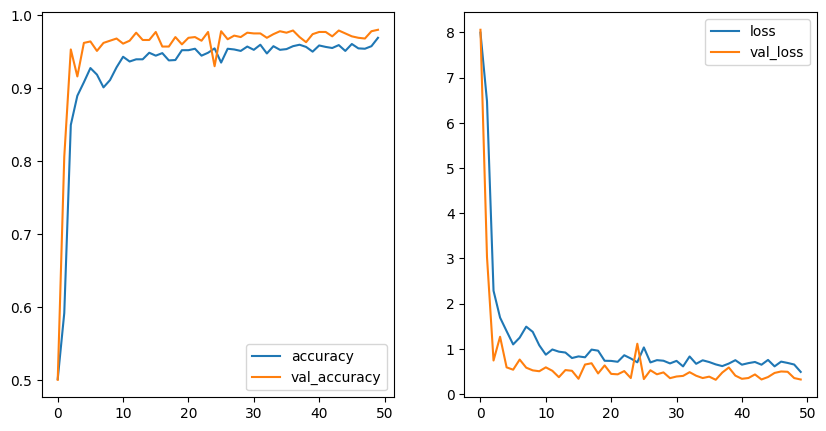

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9715 - loss: 0.4567
Test accuracy: 0.972


Model: "vgg16_freeze"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_9 (Cast)       │ (None, 180, 180,  │          0 │ input_layer_6[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ cast_9[0][0]      │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 12800)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │  3,277,056 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        257 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,269,320 (81.14 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 3,277,319 (12.50 MB)

In [24]:
# plotting the training history
plot_history(vgg16_freeze_history)

vgg16_freeze_best = keras.models.load_model("vgg16_freeze.keras")
vgg16_freeze_loss, vgg16_freeze_acc = vgg16_freeze_best.evaluate(test_dataset)
print(f"Test accuracy: {vgg16_freeze_acc:.3f}")

vgg16_freeze_best.summary()

#### Fine-Tuning the Model

In [25]:
# Unfreezing later layers for fine-tuning
vgg16_base.trainable = True
for layer in vgg16_base.layers[:-4]:
    layer.trainable = False

vgg16_freeze_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
                            loss='binary_crossentropy',
                            metrics=['accuracy']
)

vgg16_finetune_history = vgg16_freeze_model.fit(
                        train_dataset,
                        epochs = 30,
                        validation_data = validation_dataset,
                        callbacks = checkpoint_save("vgg16_finetune.keras")
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9532 - loss: 0.7321 - val_accuracy: 0.9800 - val_loss: 0.3213
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9624 - loss: 0.6000 - val_accuracy: 0.9800 - val_loss: 0.3213
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9551 - loss: 0.7007 - val_accuracy: 0.9800 - val_loss: 0.3213
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9579 - loss: 0.6667 - val_accuracy: 0.9800 - val_loss: 0.3213
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9662 - loss: 0.5434 - val_accuracy: 0.9800 - val_loss: 0.3213
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9467 - loss: 0.8380 - val_accuracy: 0.9800 - val_loss: 0.3213
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9527 - loss: 0.7093 - val_accuracy: 0.9800 - val_loss: 0.3213
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9562 - loss: 0.6778 - val_accuracy: 0.9800 - v

#### Viualizing Model-training History

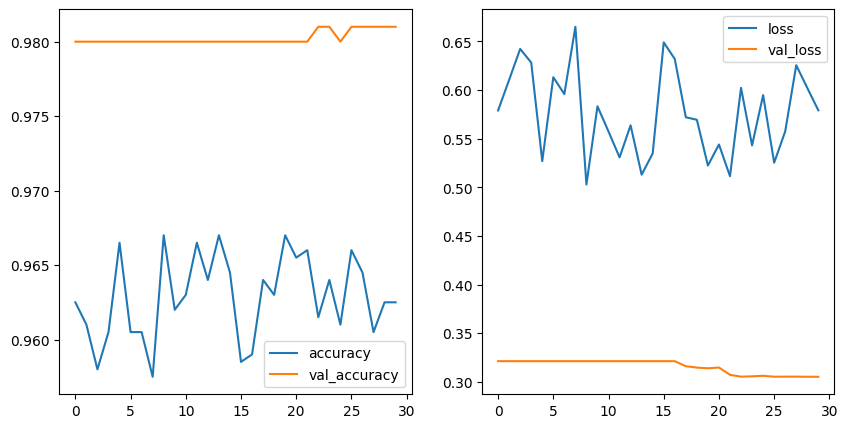

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9694 - loss: 0.4538
Test accuracy: 0.974


Model: "vgg16_freeze"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_11 (Cast)      │ (None, 180, 180,  │          0 │ input_layer_6[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ cast_11[0][0]     │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 12800)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │  3,277,056 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        257 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,269,320 (81.14 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 3,277,319 (12.50 MB)

In [26]:
# plotting the training history
plot_history(vgg16_finetune_history)

vgg16_finetune_best = keras.models.load_model("vgg16_finetune.keras")
vgg16_finetune_loss, vgg16_finetune_acc = vgg16_finetune_best.evaluate(test_dataset)
print(f"Test accuracy: {vgg16_finetune_acc:.3f}")

vgg16_finetune_best.summary()